In [1]:
#Calculating normalization for N0 contribution from tSZ Gaussian power only

In [1]:
import pytempura as cs

import numpy as np

import matplotlib.pyplot as plt

import healpy as hp

In [2]:
from falafel import utils, qe

CONFIG /global/homes/o/omard/.conda/envs/foregrounds/lib/python3.8/site-packages/falafel-0.1.0-py3.8.egg/falafel/../input/config.yml


In [3]:
import symlens as s

from pixell import enmap, utils as putils, powspec

## Define some constants and functions

In [4]:

default_tcmb = 2.726
H_CGS = 6.62608e-27
K_CGS = 1.3806488e-16
C_light = 2.99792e+10



C = 3.e8
H = 6.63e-34
KB = 1.38e-23
TCMB = 2.726
JANKSY = 1.e-26

In [5]:
default_tcmb = 2.726
H_CGS = 6.62608e-27
K_CGS = 1.3806488e-16
C_light = 2.99792e+10



C = 3.e8
H = 6.63e-34
KB = 1.38e-23
TCMB = 2.726
JANKSY = 1.e-26


def fnu(nu, tcmb = default_tcmb):
    """
    nu in GHz
    tcmb in Kelvin
    """
    nu = np.asarray(nu)
    mu = H_CGS*(1e9*nu)/(K_CGS*tcmb)
    ans = mu/np.tanh(mu/2.0) - 4.0
    return ans

def tsz_factor_for_ymap(freq, tcmb = default_tcmb):
    return fnu(freq) * tcmb * 1e6

def process_tsz(comptony, freq, tcmb = default_tcmb):
    return tsz_factor_for_ymap(freq = freq, tcmb = tcmb) * comptony

## Define lensing reconstruction set up

In [6]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 3000       # maximum multipole of output normalization
lmax  = 3000
rlmin, rlmax = 100, 3000  # CMB multipole range for reconstruction

In [7]:
L = np.linspace(0,Lmax,Lmax+1)
l = L.copy()
Lfac = (L*(L+1.))**2/(2*np.pi)

In [8]:
allelementstosave = np.load('../bin/input_cmb_145.npy')
ells, lcmb, tsz, ksz, radio, cib, dust, nl145, totalcmb, totalnoisecmb = allelementstosave.T

mlmax = 7000
ell = np.arange(mlmax+1)

fgs = tsz+ksz+radio+cib+dust
noise = fgs+nl145
noise = np.interp(ell, ells, noise)

noisepol = nl145
noisepol = np.interp(ell, ells, noisepol)

Nl_tt = np.nan_to_num(noise)



nells = {"TT": Nl_tt, "EE": 2*noisepol*0., "BB": 2*noisepol*0.}
ucls, tcls = utils.get_theory_dicts(grad = True, nells = nells, lmax = mlmax)


THEORY /global/homes/o/omard/fgestimates/


/global/homes/o/omard/.conda/envs/foregrounds/lib/python3.8/site-packages/orphics-0.1-py3.8.egg/orphics/cosmology.py:855: RuntimeWarning: divide by zero encountered in true_divide
  lfact = 2.*np.pi/ell/(ell+1.) if not(dells) else 1
/global/homes/o/omard/.conda/envs/foregrounds/lib/python3.8/site-packages/orphics-0.1-py3.8.egg/orphics/cosmology.py:857: RuntimeWarning: invalid value encountered in multiply
  lcltt *= mult
/global/homes/o/omard/.conda/envs/foregrounds/lib/python3.8/site-packages/orphics-0.1-py3.8.egg/orphics/cosmology.py:858: RuntimeWarning: invalid value encountered in multiply
  lclee *= mult
/global/homes/o/omard/.conda/envs/foregrounds/lib/python3.8/site-packages/orphics-0.1-py3.8.egg/orphics/cosmology.py:859: RuntimeWarning: invalid value encountered in multiply
  lclte *= mult
/global/homes/o/omard/.conda/envs/foregrounds/lib/python3.8/site-packages/orphics-0.1-py3.8.egg/orphics/cosmology.py:860: RuntimeWarning: invalid value encountered in multiply
  lclbb *= mult

In [9]:
est_norm_list = ['TT']
Als = cs.get_norms(est_norm_list ,ucls,tcls, rlmin, rlmax, k_ellmax = mlmax)

In [10]:
ls = np.arange(Als['TT'][0].size)

Nl_g = Als['TT'][0] * (ls*(ls+1.)/2.)**2. #this is the total N0

In [11]:
shape, wcs = enmap.geometry(shape = (512,512), res = 2.0*putils.arcmin, pos = (0,0))
modlmap = enmap.modlmap(shape, wcs)


f = s.Ldl1 * s.e('uC_T_T_l1') + s.Ldl2 * s.e('uC_T_T_l2')
F = f / 2 / s.e('tC_T_T_l1') / s.e('tC_T_T_l2')
expr1 = f * F
feed_dict = {}
feed_dict['uC_T_T'] = s.interp(ell, ucls['TT'])(modlmap)
feed_dict['tC_T_T'] = s.interp(ell,tcls['TT'])(modlmap)

In [12]:
xmask = s.mask_kspace(shape,wcs,lmin=rlmin,lmax=rlmax)
integral = s.integrate(shape,wcs,feed_dict,expr1,xmask=xmask,ymask=xmask).real
Nl = (modlmap*(modlmap+1)/2.)**2/integral
bin_edges = np.arange(10,3000,40)
binner = s.bin2D(modlmap,bin_edges)
cents,nl1d = binner.bin(Nl)

/tmp/ipykernel_23671/3516339892.py:3: RuntimeWarning: invalid value encountered in true_divide
  Nl = (modlmap*(modlmap+1)/2.)**2/integral


(1.0613742634215463e-07, 0.0001)

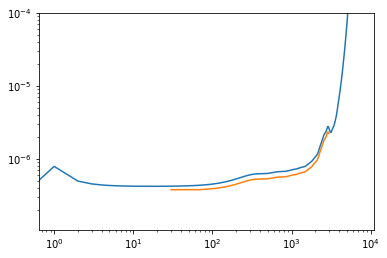

In [13]:
plt.loglog(Nl_g*4)
plt.loglog(cents, nl1d)
plt.ylim(ymax = 1e-4)

In [60]:
factor = tsz_factor_for_ymap(freq = 145)

sehgal_sims_dir = '/global/cscratch1/sd/omard/scatteringtfms/sims/'

key = 'tsz'
key = 'cib'

tsz_map = hp.read_alm(f'{sehgal_sims_dir}{key}_alm.fits')
#tsz_map_randomized = hp.read_alm(f'{sehgal_sims_dir}{key}_randomized_alm.fits') 

clstsz = hp.alm2cl(tsz_map)
#clstsz_randomized = hp.alm2cl(tsz_map_randomized)

lss = np.arange(0, len(clstsz), 1)

factor = 1 if key != 'tsz' else factor


In [104]:
f = lambda size: np.exp(1j*np.random.uniform(0., 2.*np.pi, size = size))
size = len(tsz_map)
factors = f(size)
tsz_map_randomized_alm = hp.almxfl(tsz_map, factors) #hp.read_alm(f'{source_dir}/tsz_randomized_alm.fits')

In [105]:
clstsz_randomized = hp.alm2cl(tsz_map_randomized_alm)

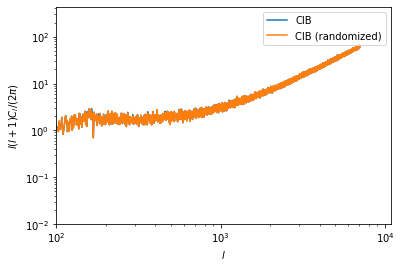

In [108]:
plt.loglog(clstsz*lss*(lss+1)/(2*np.pi), label = 'CIB')
plt.loglog(clstsz_randomized*lss*(lss+1)/(2*np.pi), label = 'CIB (randomized)')
plt.xlim(100)
plt.ylim(1e-2)
plt.ylabel('$l(l+1)C_l/(2\pi)$')
plt.xlabel('$l$')
plt.legend()

In [73]:
feed_dict['dC_T_T'] = np.nan_to_num(s.interp(lss, clstsz)(modlmap))*factor**2.
feed_dict['nC_T_T'] = np.nan_to_num(s.interp(lss, clstsz)(modlmap))*factor**2.

RDN0 = s.RDN0_analytic(shape,wcs,feed_dict,'hu_ok','TT','hu_ok','TT', xmask = xmask, ymask = xmask)

In [74]:
cents, n0 = binner.bin(RDN0)

(1e-11, 0.0001)

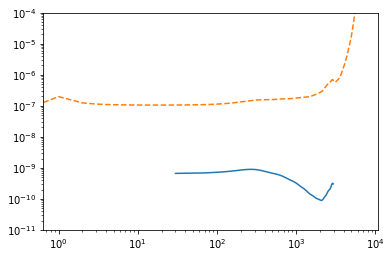

In [77]:
plt.loglog(cents, n0, label = 'N0')
plt.loglog(Nl_g, ls = '--')
plt.ylim(1e-11, 1e-4)


In [109]:
all_spectra = np.load('../bin/all_spectra_randomized_3000.npy',  allow_pickle = True) if key == 'tsz' else np.load(f'../bin/all_spectra_{key}_randomized_3000.npy',  allow_pickle = True)

In [110]:
ctsz = f'{key}'
ctszr = f'{key}_randomized'

dd = all_spectra.item().get(ctszr)
dd['qe']['oo']

array([0.00000000e+00, 1.84235314e-10, 7.09401237e-09, ...,
       1.50659881e+09, 1.47815847e+09, 0.00000000e+00])

Text(0, 0.5, '$C_L^{kk}$')

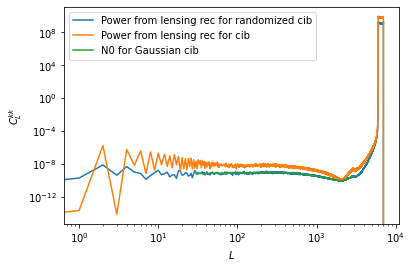

In [114]:
plt.loglog(dd['qe']['oo'], label = f'Power from lensing rec for randomized {key}')
plt.loglog(all_spectra.item().get(ctsz)['qe']['oo'], label = f'Power from lensing rec for {key}')
plt.loglog(cents, n0, label = f'N0 for Gaussian {key}')
plt.legend()
plt.xlabel('$L$')
plt.ylabel('$C_L^{kk}$')

Text(0, 0.5, '$C_L^{kk}$')

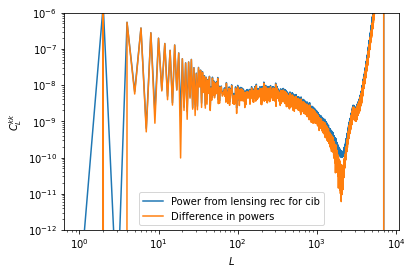

In [113]:
plt.loglog(all_spectra.item().get(ctsz)['qe']['oo'], label = f'Power from lensing rec for {key}')
plt.loglog(all_spectra.item().get(ctsz)['qe']['oo']-dd['qe']['oo'], label = 'Difference in powers')
plt.ylim(1e-12, 1e-6)
plt.legend()
plt.xlabel('$L$')
plt.ylabel('$C_L^{kk}$')